In [69]:
from src.plotting.visutil import CSVPlotter
from src.plotting.postprocess import PostProcessor
from config.plotsetting import object_dict
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Produce ABCD table

Region A is defined as: OS + 2 b-tagged \
Region B is defined as: OS + 1 b-tagged \
Region C is defined as: SS + 2 b-tagged \
Region D is defined as: SS + 1 b-tagged

In [70]:
def add_inv_mass(df):
    # get deltaR and select OS
    from src.analysis.objutil import Object
    df.rename(columns=lambda x: x.replace('LDTau', 'LeadingTau'), inplace=True)
    df.rename(columns=lambda x: x.replace('SDTau', 'SubleadingTau'), inplace=True)
    leading_tau = Object.fourvector(df, 'LeadingTau', sort=False)
    subleading_tau = Object.fourvector(df, 'SubleadingTau', sort=False)
    df['Tau_dR'] = leading_tau.deltaR(subleading_tau)
    ld_jet = Object.fourvector(df, 'LDBjetBYtag', sort=False)
    sd_jet = Object.fourvector(df, 'SDBjetBYtag', sort=False)
    df['Bjet_dR'] = ld_jet.deltaR(sd_jet)
    df['Tau_InvM'] = (leading_tau+subleading_tau).mass
    df['Bjet_InvM'] = (ld_jet+sd_jet).mass
    df['OS'] = df['LeadingTau_charge']*df['SubleadingTau_charge'] < 0

In [71]:
def selOS(df):
    add_inv_mass(df)
    OS_df = df[df['OS']]
    return OS_df

def selSS(df):
    add_inv_mass(df)
    SS_df = df[~df['OS']]
    return SS_df

In [72]:
cp = CSVPlotter(outdir='/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots')
dfB = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selOS, selname='OS Tau')
dfA = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selOS, selname='OS Tau')

In [74]:
# save dataframes for further processing
dfB.to_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionB.csv")
dfA.to_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionA.csv")

In [75]:
# calculate total cutflow
inputpath1='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb_extrasel'
pp = PostProcessor()
pp.merge_cf(inputdir=inputpath1, outputdir=inputpath1)
inputpath2='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb_extrasel'
pp.merge_cf(inputdir=inputpath2, outputdir=inputpath2)

In [76]:
def ABCDTable():
    AC_df = pd.read_csv(f'{inputpath2}/scaledyield.csv')
    AC_df.drop(columns=['Sig Eff', 'Bkg Eff'], inplace=True)
    AC_df = AC_df.apply(pd.to_numeric, errors='coerce')
    BD_df = pd.read_csv(f'{inputpath1}/scaledyield.csv')
    BD_df = BD_df.apply(pd.to_numeric, errors='coerce')
    BD_df.drop(columns=['Sig Eff', 'Bkg Eff'], inplace=True)
    A_row = AC_df.iloc[-1]
    C_row = AC_df.iloc[-2]-AC_df.iloc[-1]
    B_row = BD_df.iloc[-1]
    D_row = BD_df.iloc[-2]-BD_df.iloc[-1]
    ABCD_tab = pd.DataFrame([A_row, B_row, C_row, D_row])
    ABCD_tab['SvB Ratio'] = ABCD_tab['Tot Sig']/ABCD_tab['Tot Bkg']
    ABCD_tab.index = ['Region A', 'Region B', 'Region C', 'Region D']
    ABCD_tab = ABCD_tab.dropna(axis=1, how='any')
    ABCD_tab.to_csv('/Users/yuntongzhou/Desktop/Dihiggszztt/output/ABCD.csv')
    return ABCD_tab

In [77]:
ABCDTable()

,DYJets,SingleH,TTbar,WW,WWW,WZ,Tot Bkg,ggF,ZH,ZZ,Tot Sig,SvB Ratio
Region A,2542.166270,66.112722,7622.339871,11.455759,0.456910,58.877173,10301.408704,6.750938,12.754023,21.782515,41.287476,0.004008
Region B,12638.542262,331.089209,5329.562496,72.556388,3.236442,297.803209,18672.790007,3.453599,6.896976,49.916996,60.267571,0.003228
Region C,84.337270,5.339009,831.877334,2.464453,0.342682,9.207665,933.568414,0.182941,0.296541,1.501346,1.980828,0.002122
Region D,734.939064,10.094546,851.857929,10.348755,1.675335,52.667017,1661.582647,0.097930,0.271563,4.742555,5.112047,0.003077


In [108]:
dfD = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selSS, selname='SS Tau')
dfC = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selSS, selname='SS Tau')

## Make Plots for Background vs Signal Distribution in four regions

In [117]:
from config.plotsetting import tau_gen, bjetbytag_btag, H_mass, dR

In [110]:
bkg_only = {"DYJets": ["DYJets"], "TTbar": ["TTbar"], "SingleH": ["SingleH"], "Others": ["WZ", "WWW", "WW"], "QCD": ["QCD"]}
sig_only = {r"ZH $\times 100$": ["ZH"], r"ggF $\times 100$": ["ggF"], r"ZZ $\times 100$": ["ZZ"]}
sig_total = {"Signal x 10": ["ZH", "ggF", "ZZ"]}
QCD_excluded = {"DYJets": ["DYJets"], "TTbar": ["TTbar"], "SingleH": ["SingleH"], "Others": ["WZ", "WWW", "WW"]}

In [111]:
def plotSVB_4_regions(attri_dict):
    cp.plot_SVB(dfA, attri_dict, sgroup=sig_only, bgroup=QCD_excluded, title='Region A', save_name='_RegionA')
    cp.plot_SVB(dfB, attri_dict, sgroup=sig_only, bgroup=QCD_excluded, title='Region B', save_name='_RegionB')
    cp.plot_SVB(dfC, attri_dict, sgroup=sig_only, bgroup=QCD_excluded, title='Region C', save_name='_RegionC')
    cp.plot_SVB(dfD, attri_dict, sgroup=sig_only, bgroup=QCD_excluded, title='Region D', save_name='_RegionD')

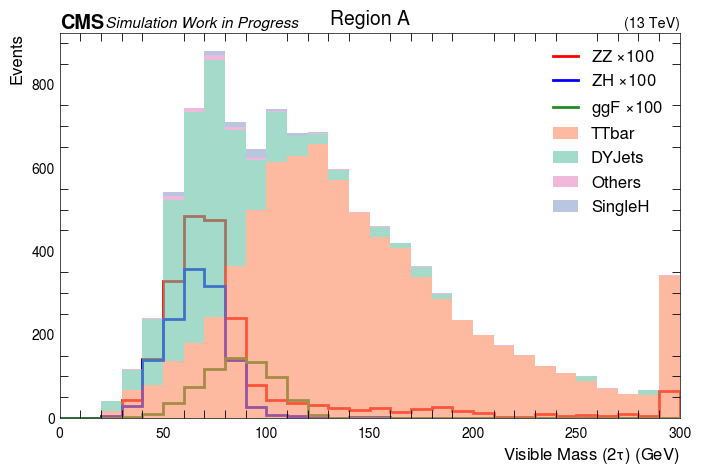

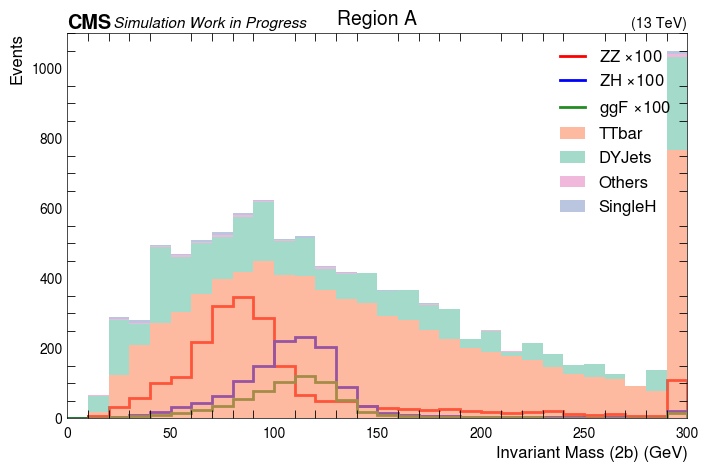

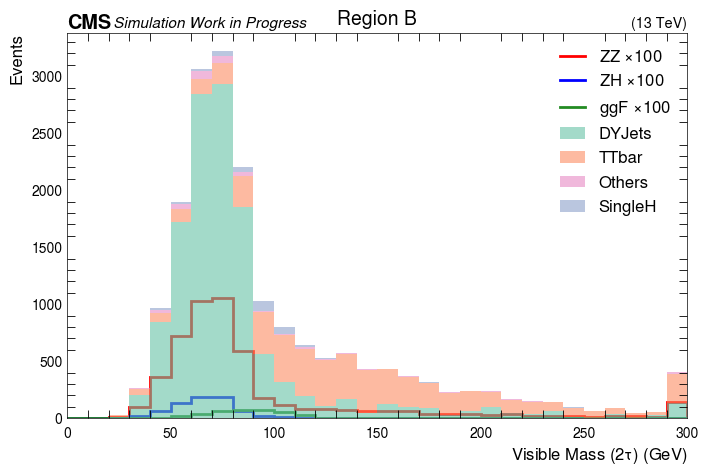

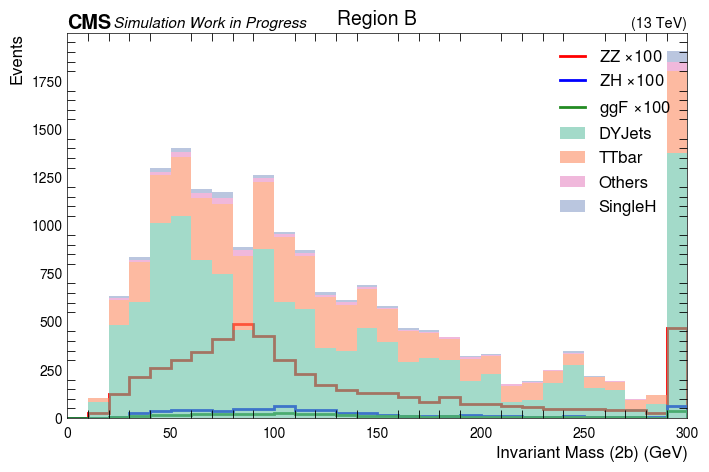

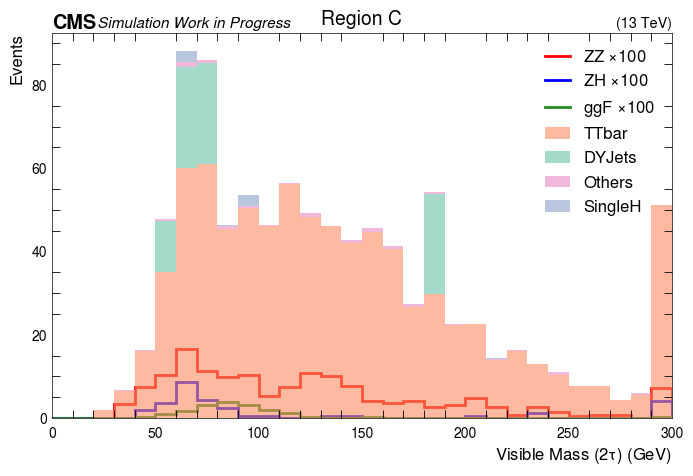

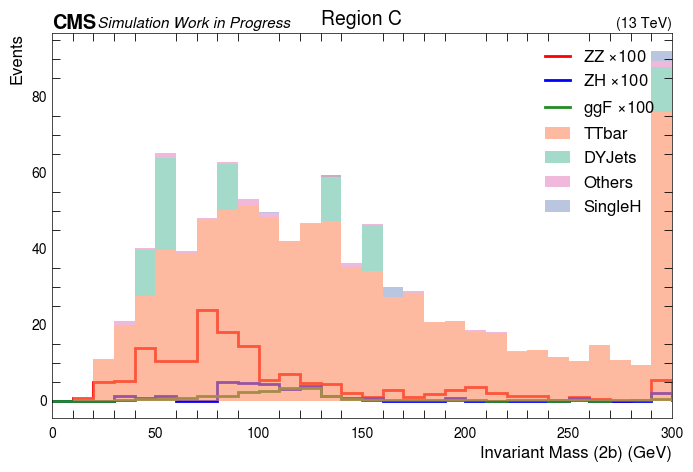

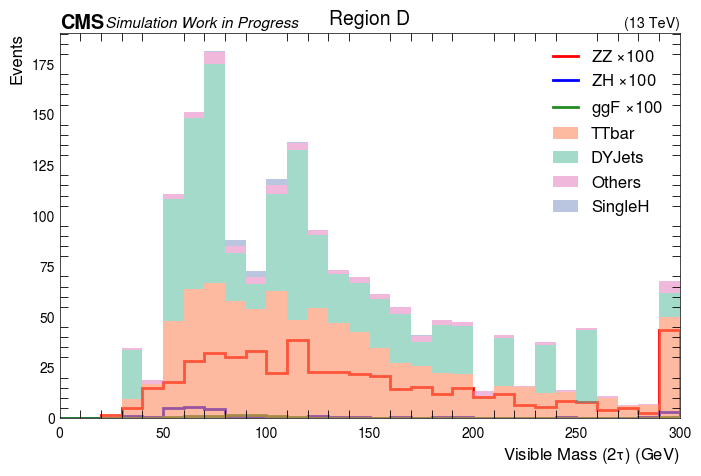

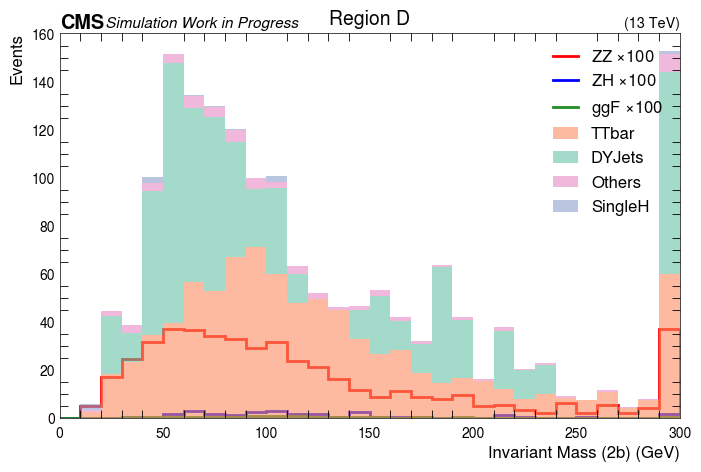

In [112]:
plotSVB_4_regions(H_mass)

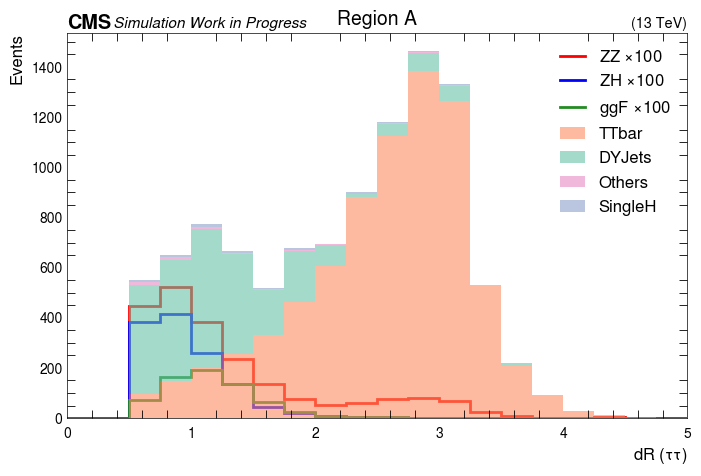

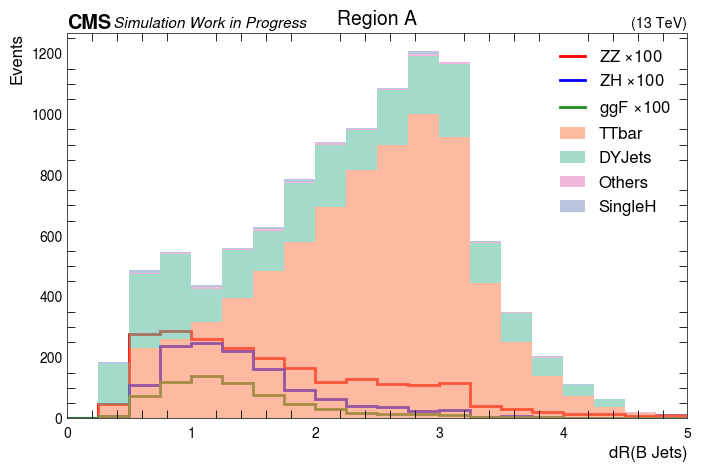

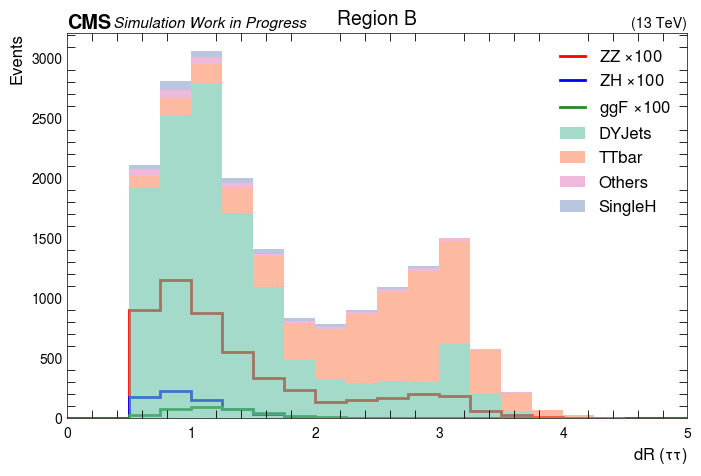

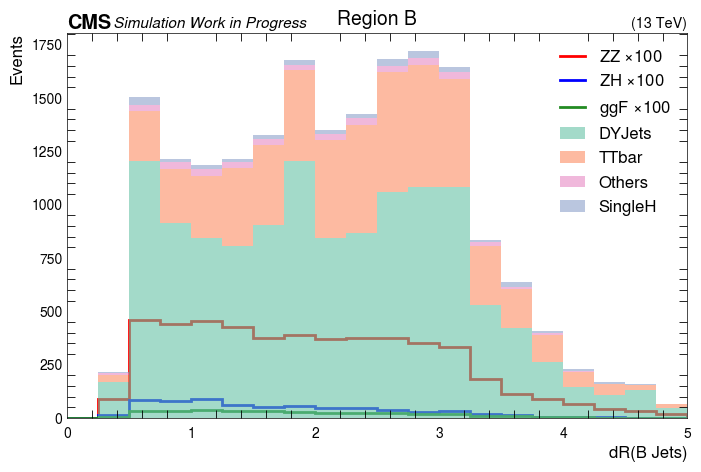

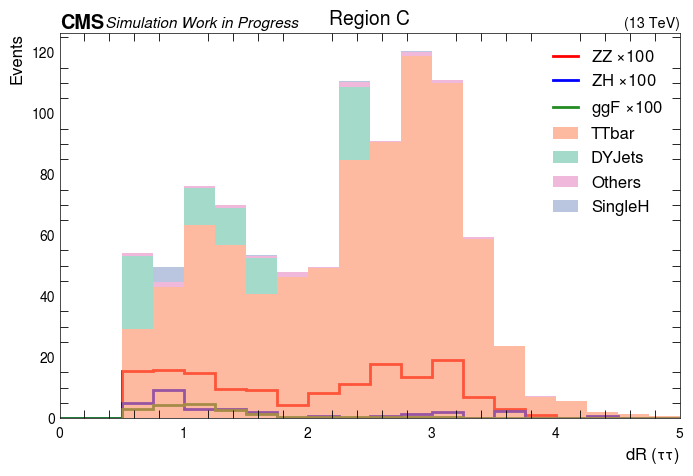

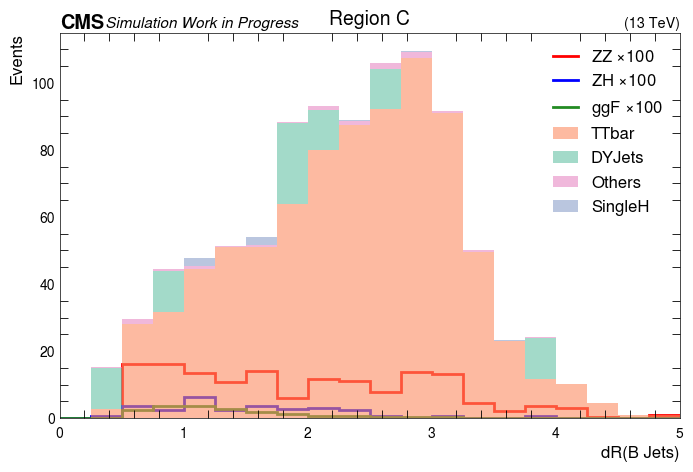

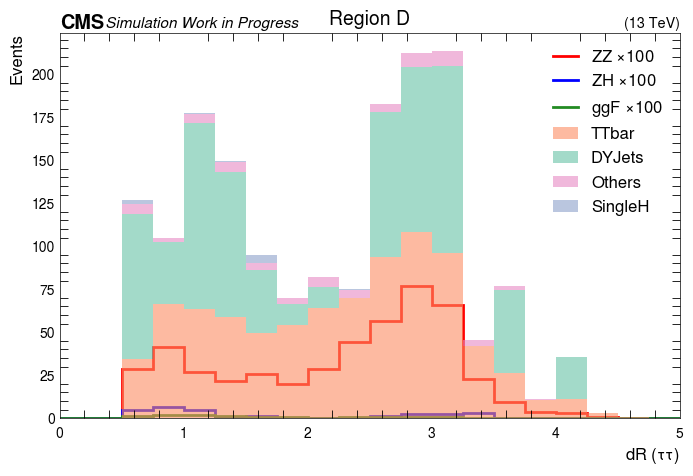

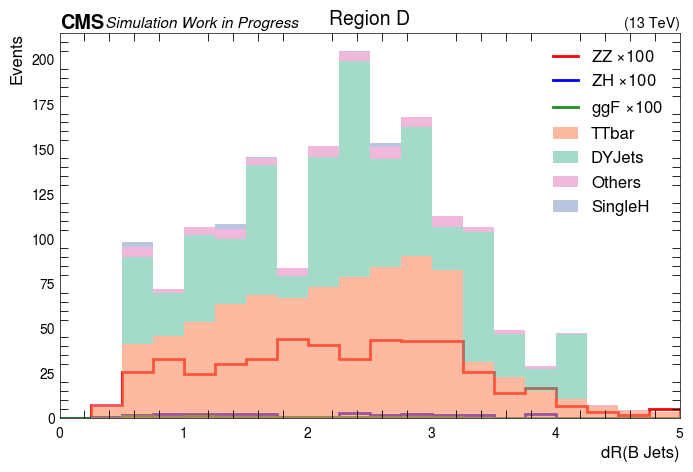

In [118]:
plotSVB_4_regions(dR)

## Make Plots for Background Distribution in four regions

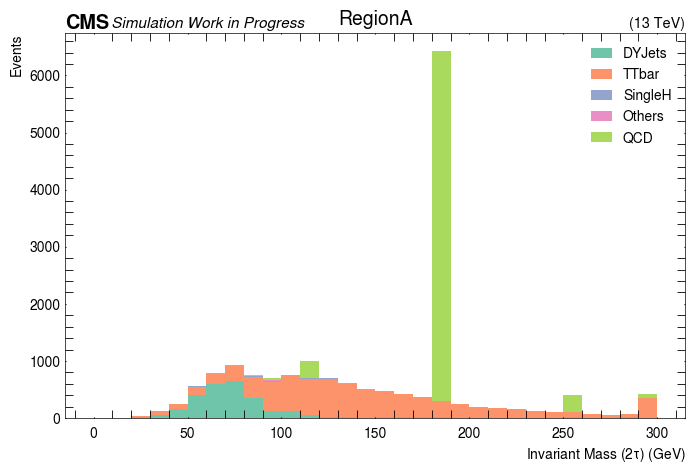

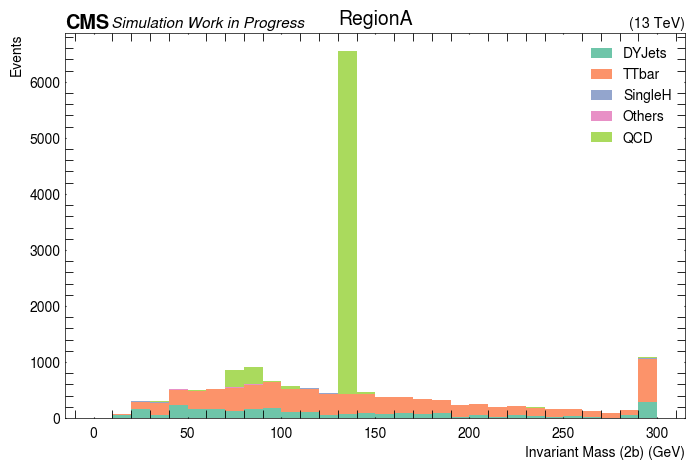

In [39]:
# See difference in Region A and Region B
cp = CSVPlotter("/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots")
cp.plot_hist(dfA, H_mass, group=bkg_only, title='RegionA', save_name='_RegionA')

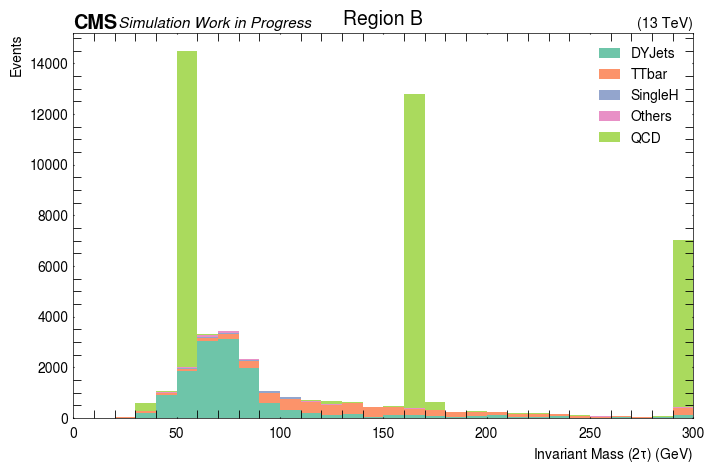

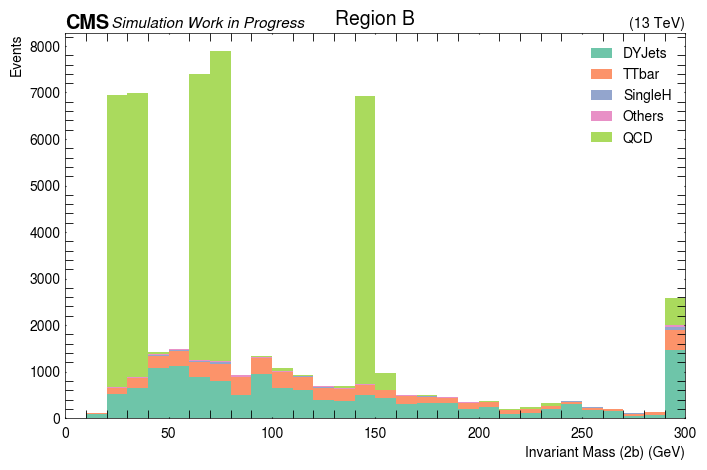

In [52]:
cp.plot_hist(dfB, H_mass, group=bkg_only, title='Region B', save_name='_RegionB')

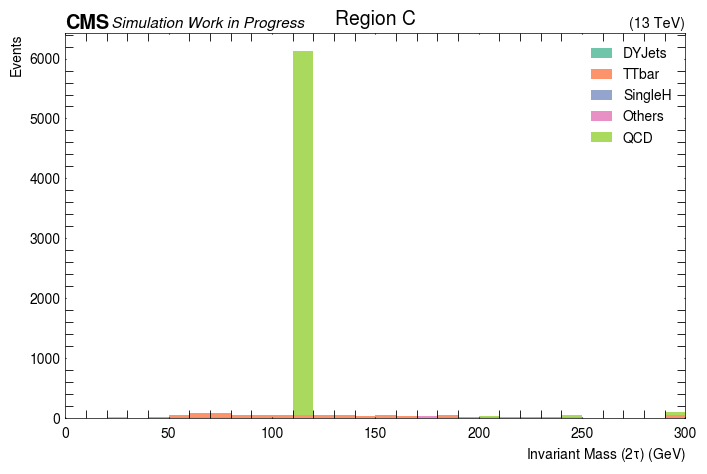

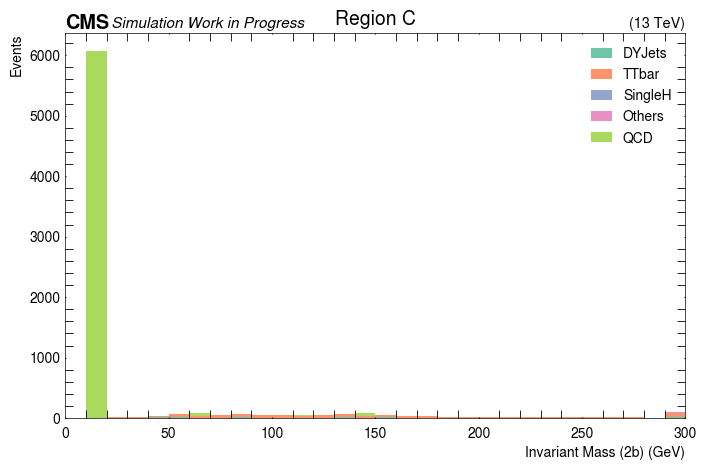

In [53]:
# See difference in Region C and Region D
cp = CSVPlotter("/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots")
cp.plot_hist(dfC, H_mass, group=bkg_only, title='Region C', save_name='_RegionC')

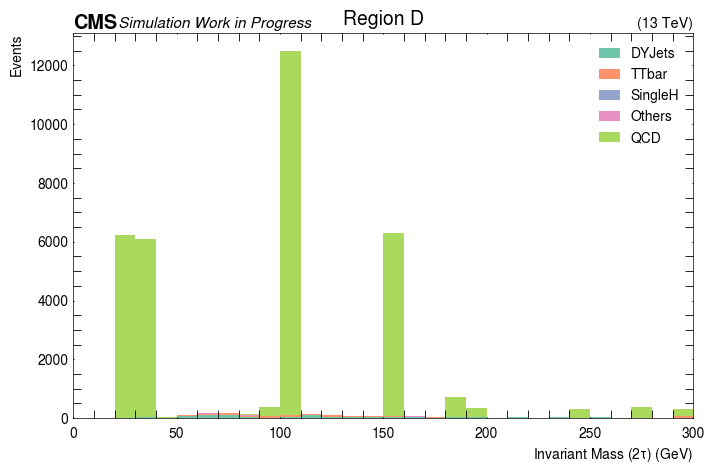

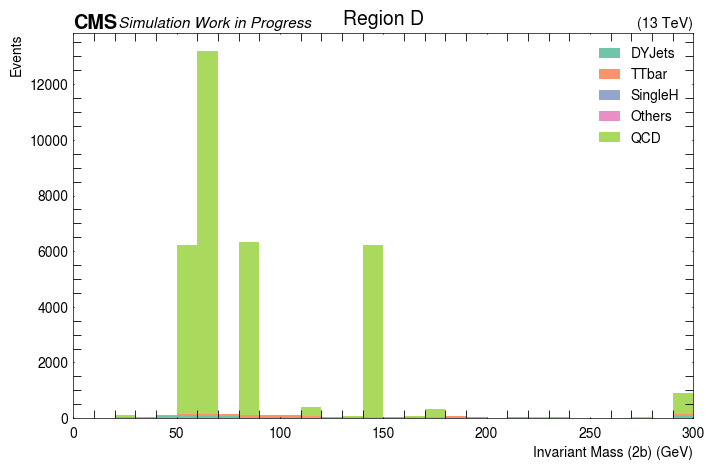

In [54]:
cp.plot_hist(dfD, H_mass, group=bkg_only, title='Region D', save_name='_RegionD')

## Add CSV cutflows

## Make plots

In [39]:
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
finame = '/Users/yuntongzhou/Desktop/Dihiggszztt/output/hadded/prelim_looseb/datasource/processed.csv'
df = pd.read_csv(finame, index_col=0)

In [33]:
sig_sep = {"DYJets": ["DYJets"], "ZH": ["ZH"], "ggF": ["ggF"], "TTbar": ["TTbar"], "ZZ": ["ZZ"], 
         "SingleH": ["SingleH"],
         "Others": ["WZ", "WWW", "WW"]}

In [48]:
svb_grp = 

In [35]:
group = {"DYJets": ["DYJets"],
         "SingleH": ["SingleH"],
         "ZH": ["ZH"], "ggF": ["ggF"]}

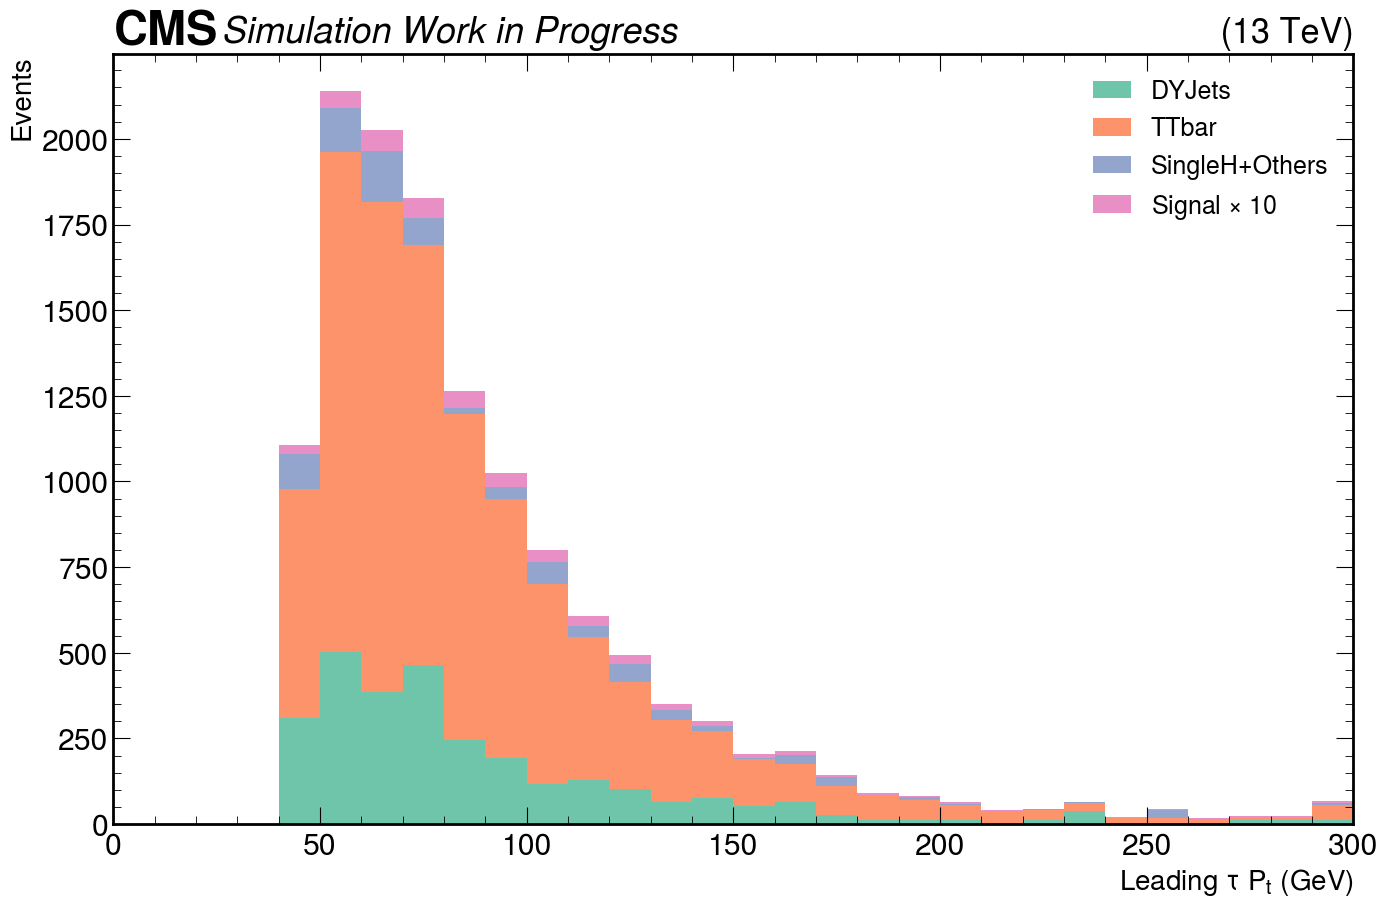

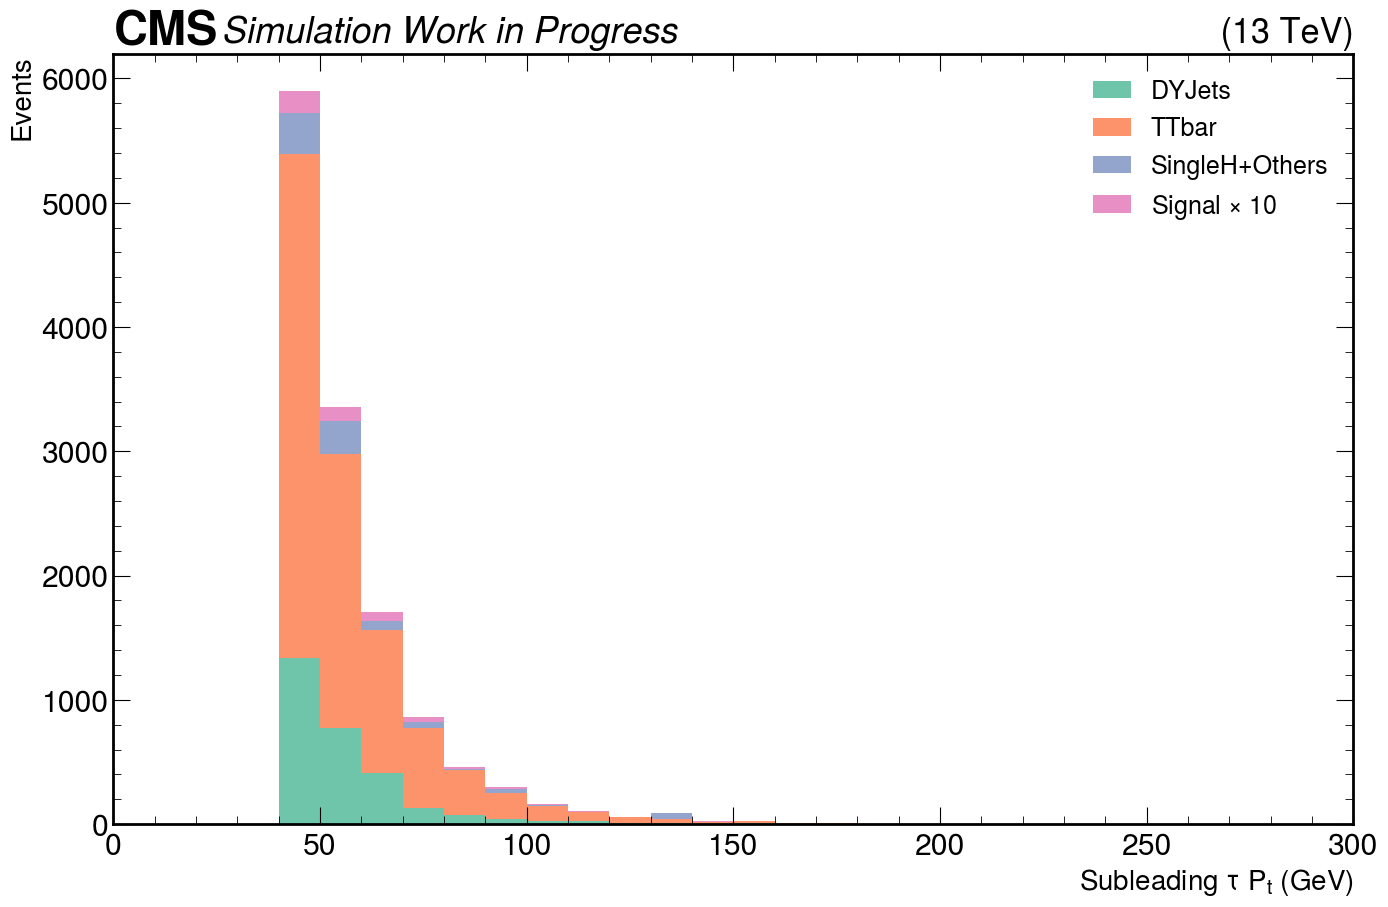

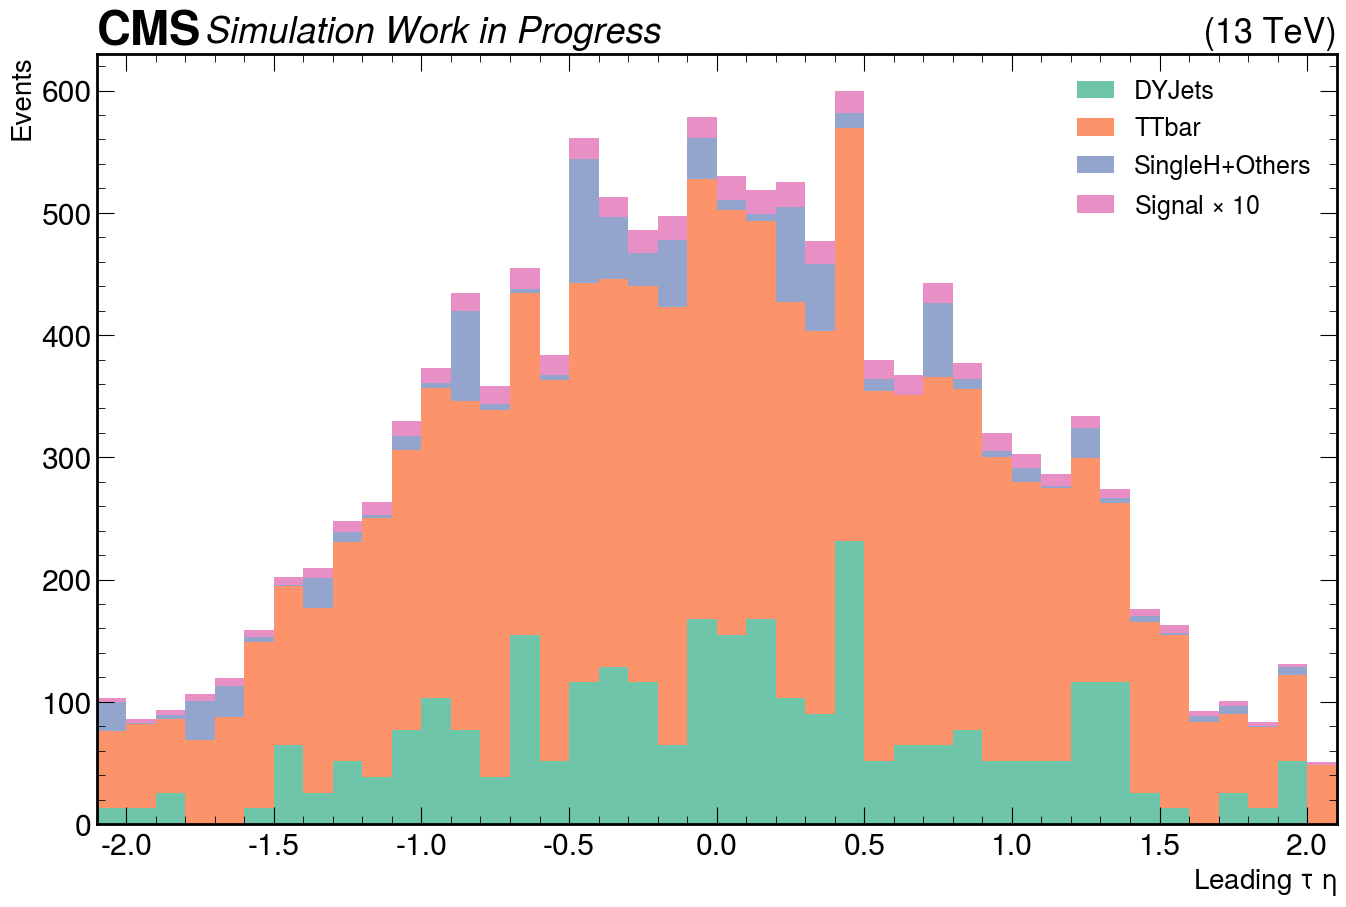

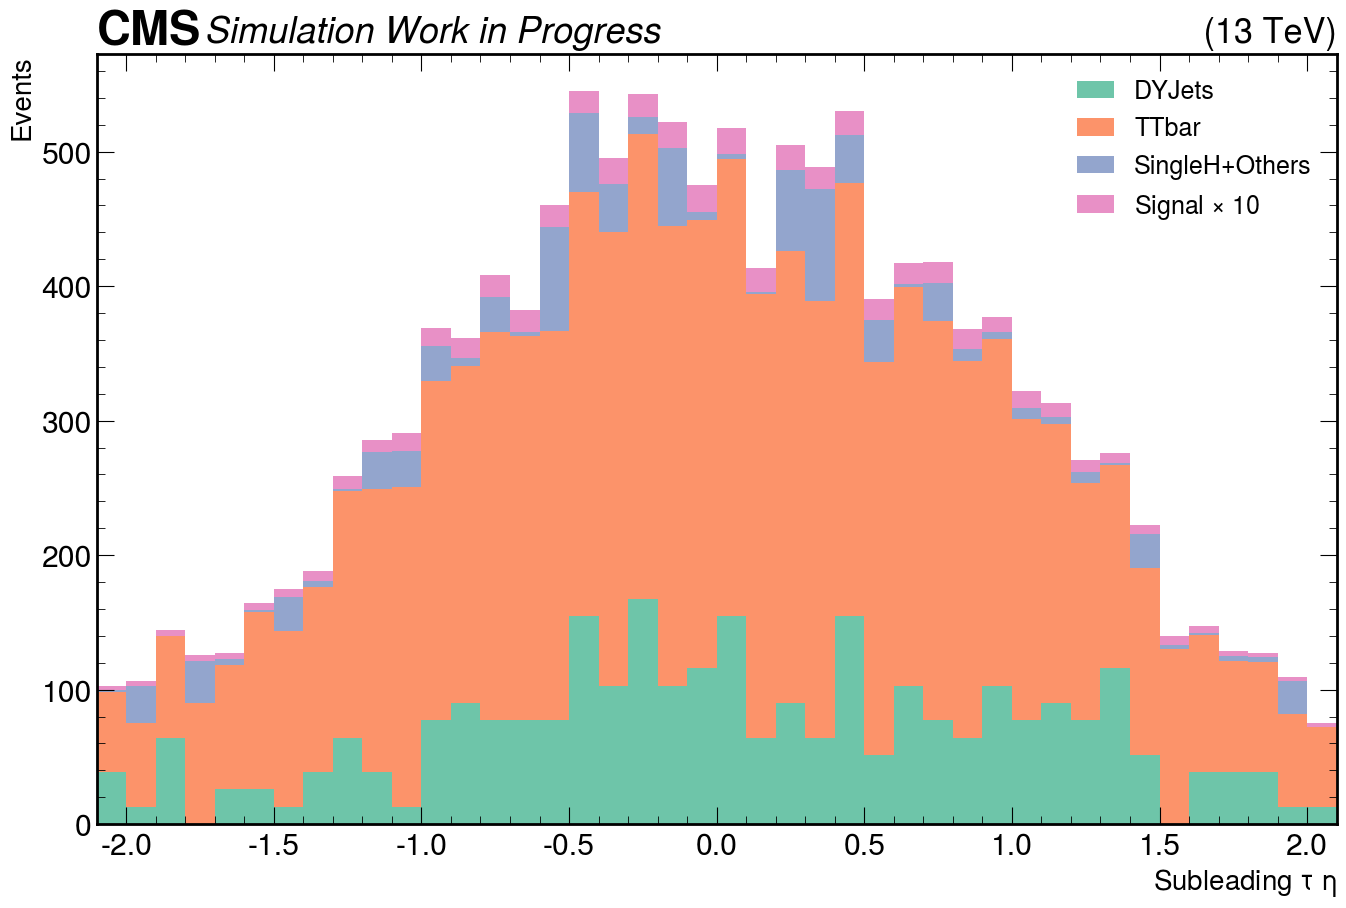

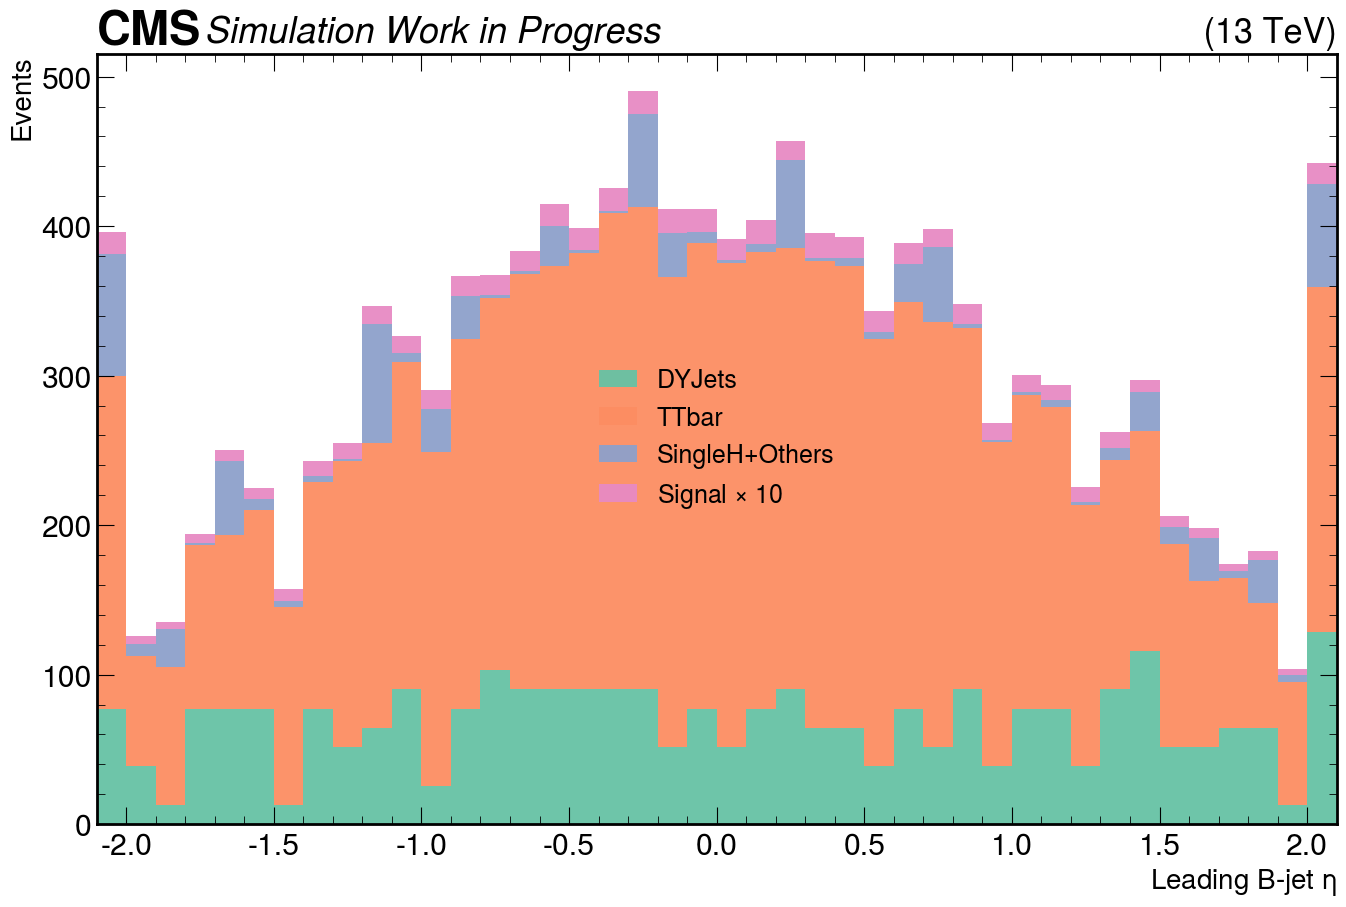

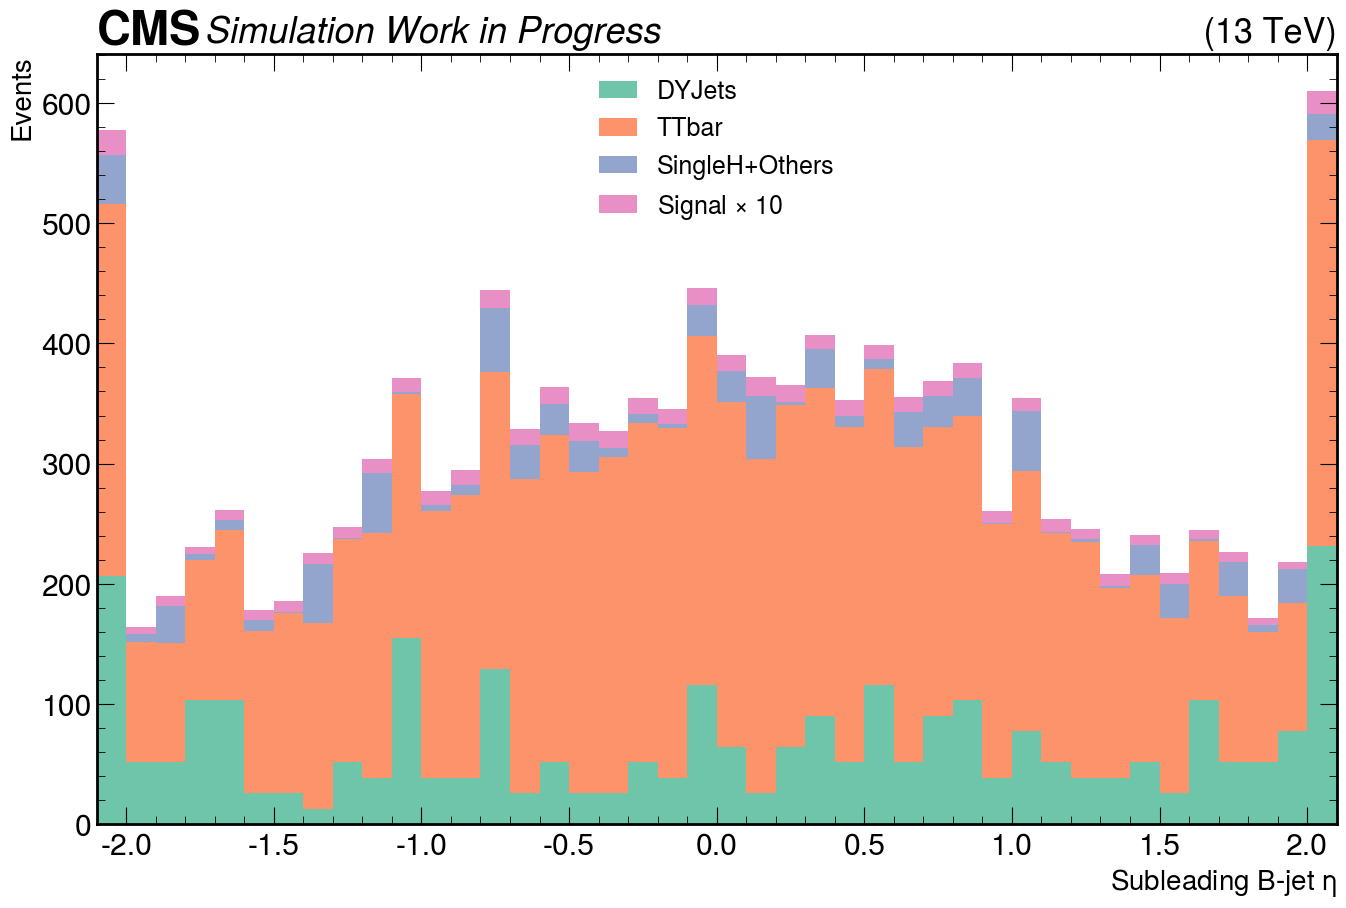

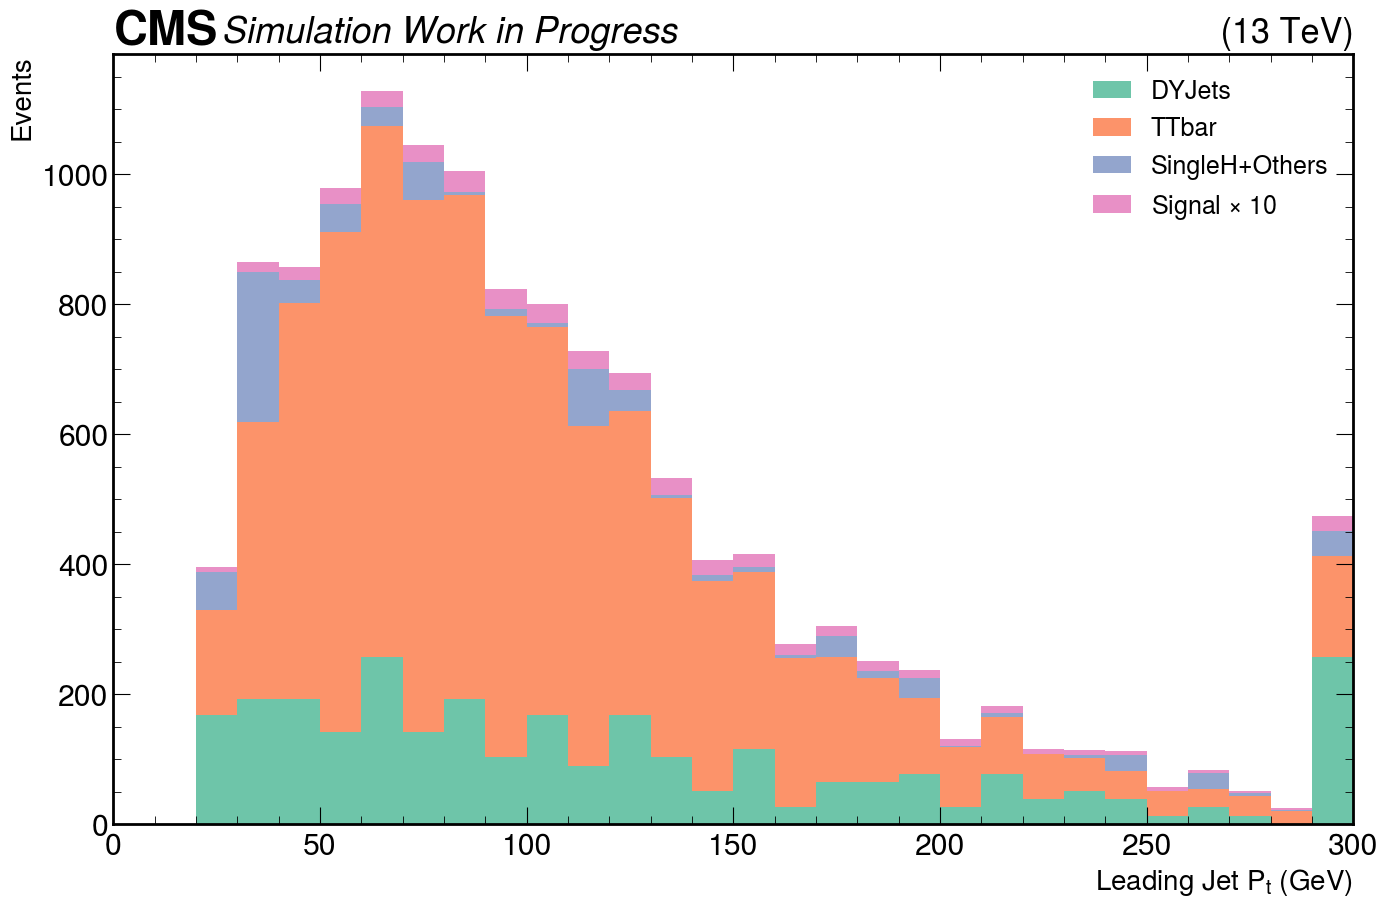

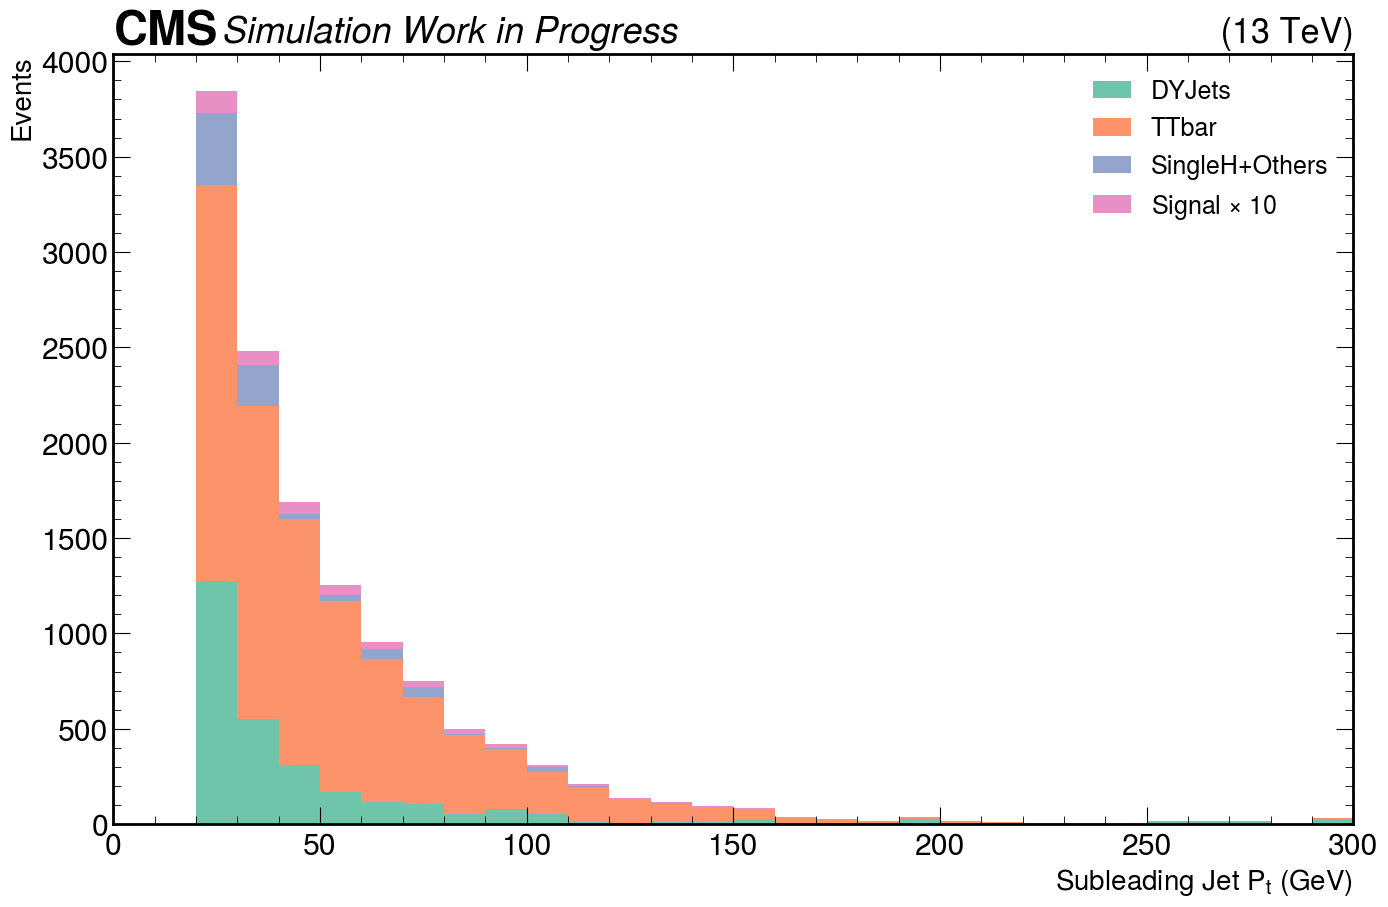

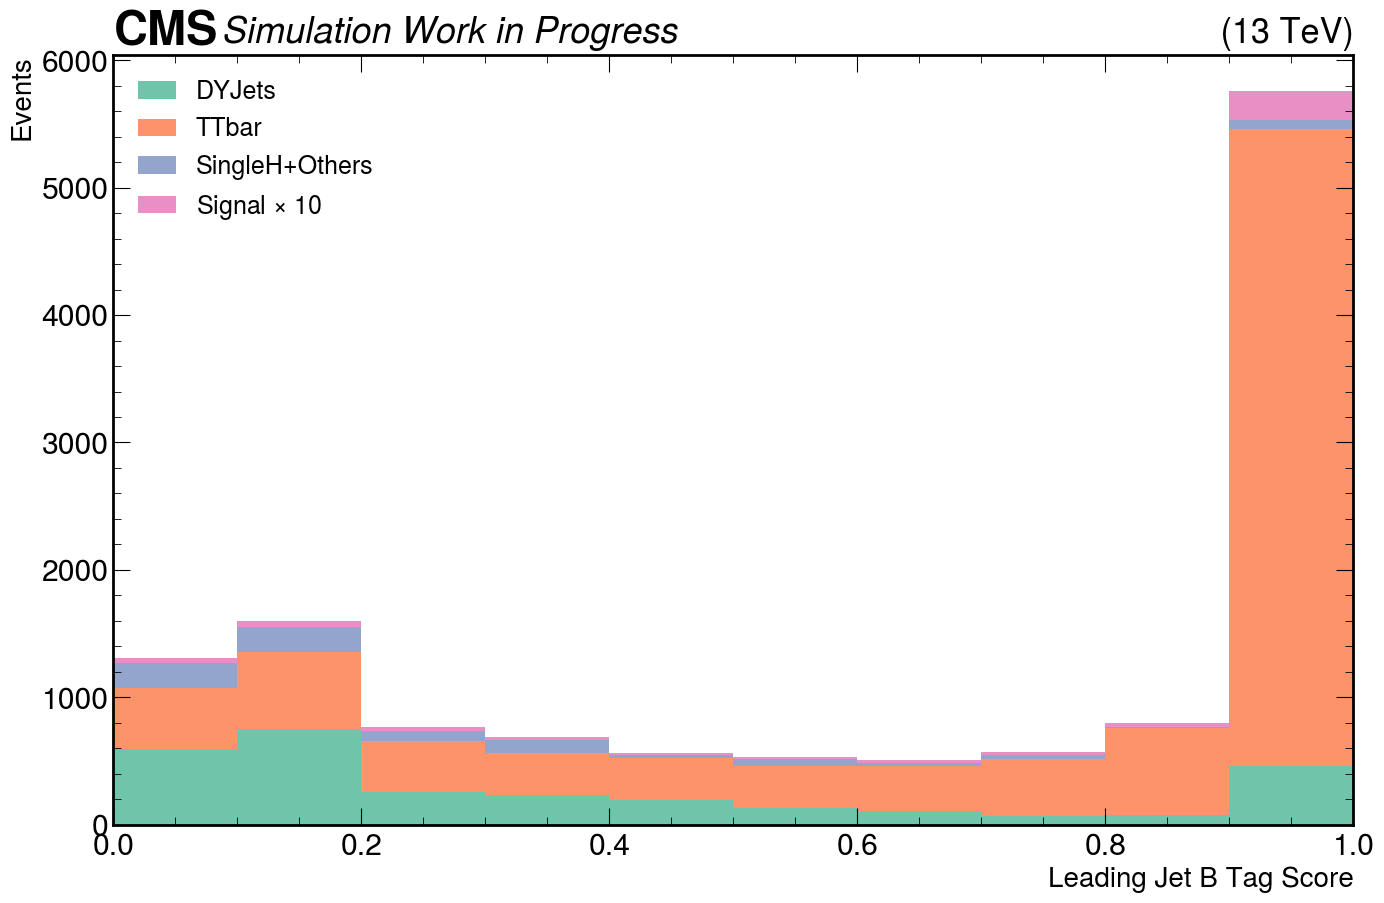

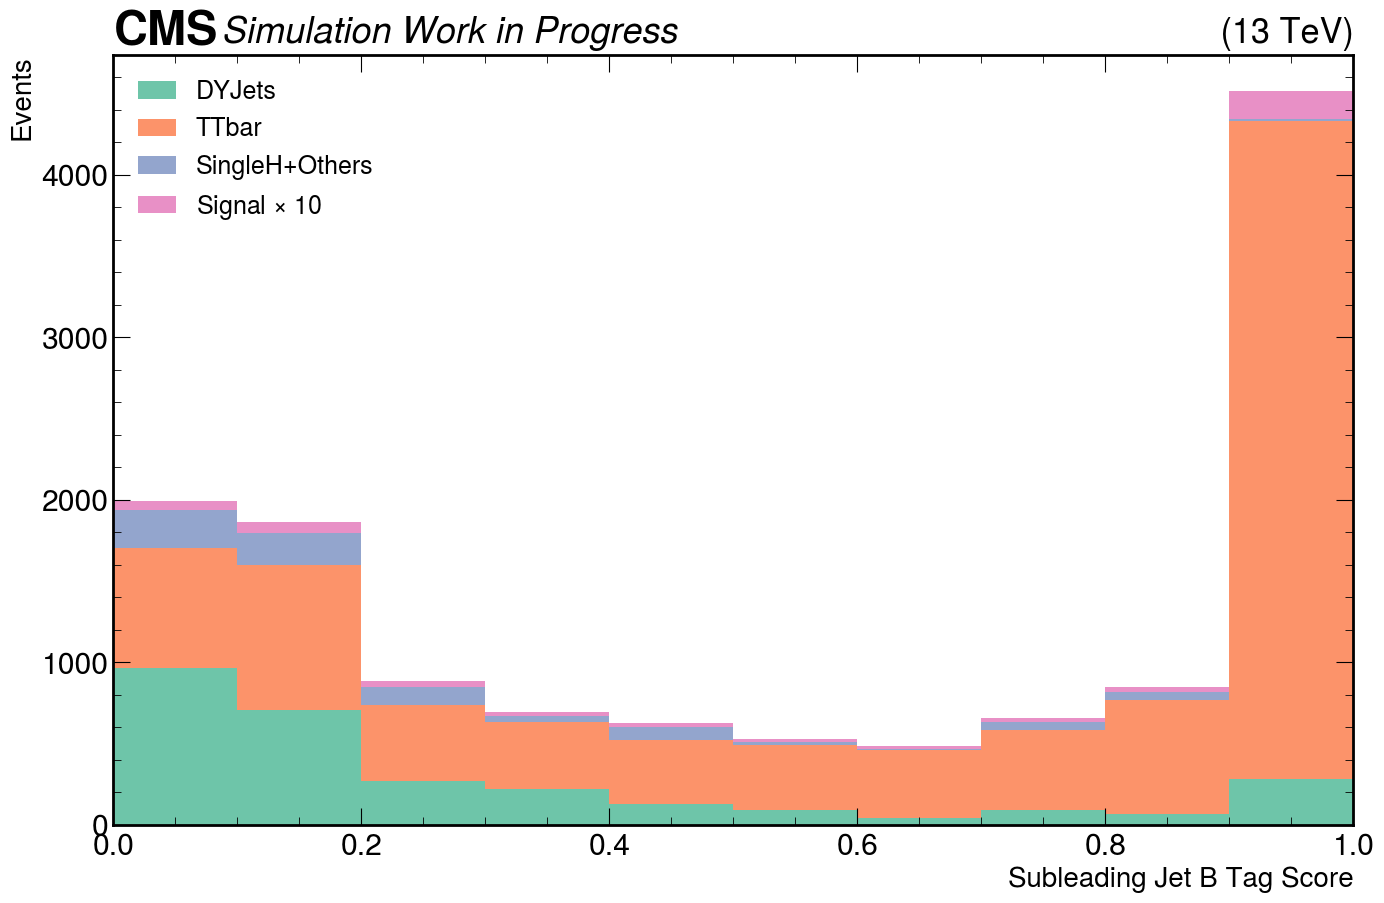

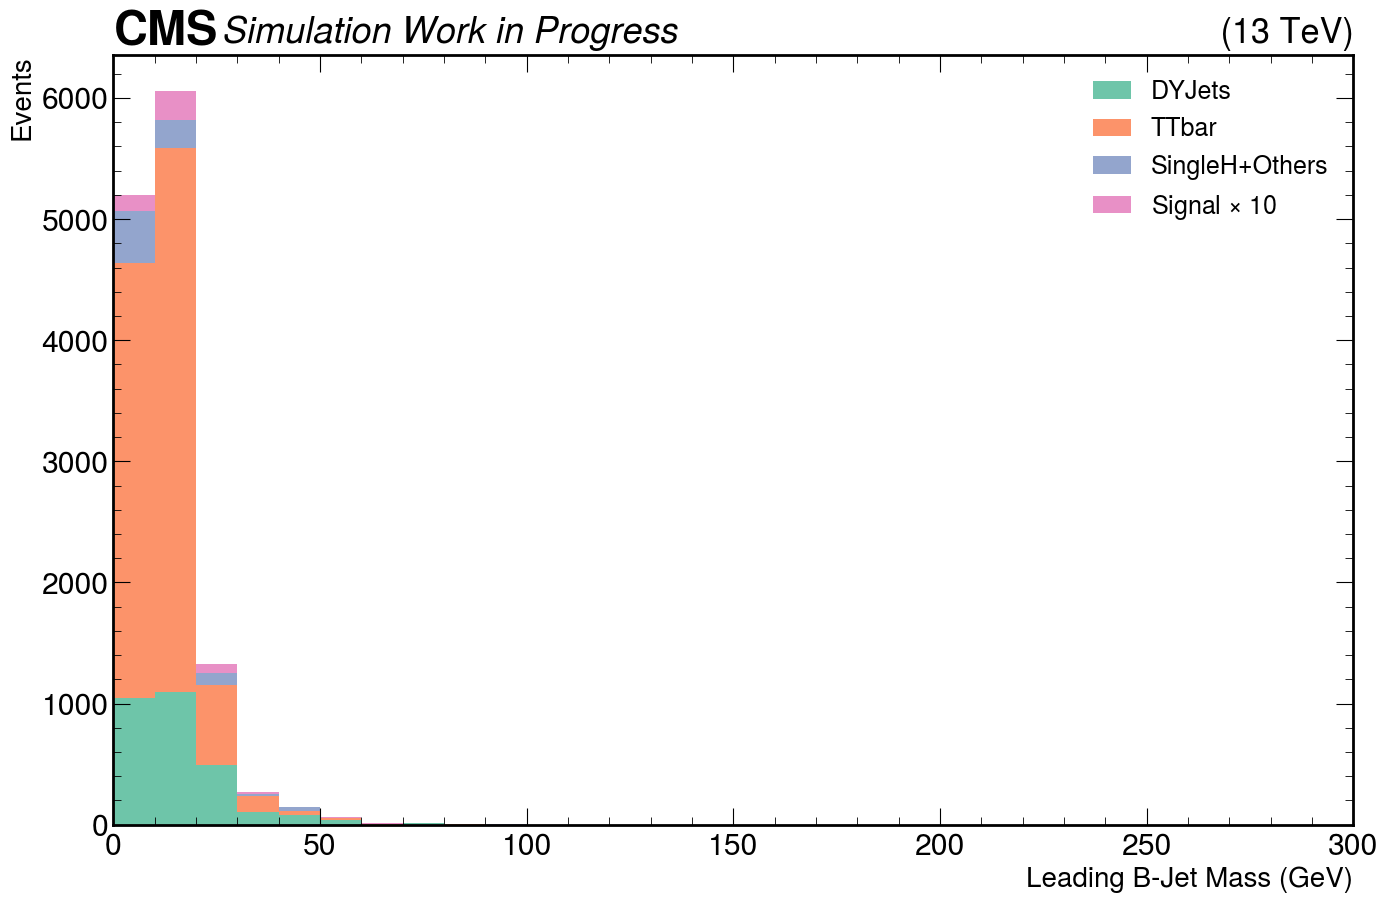

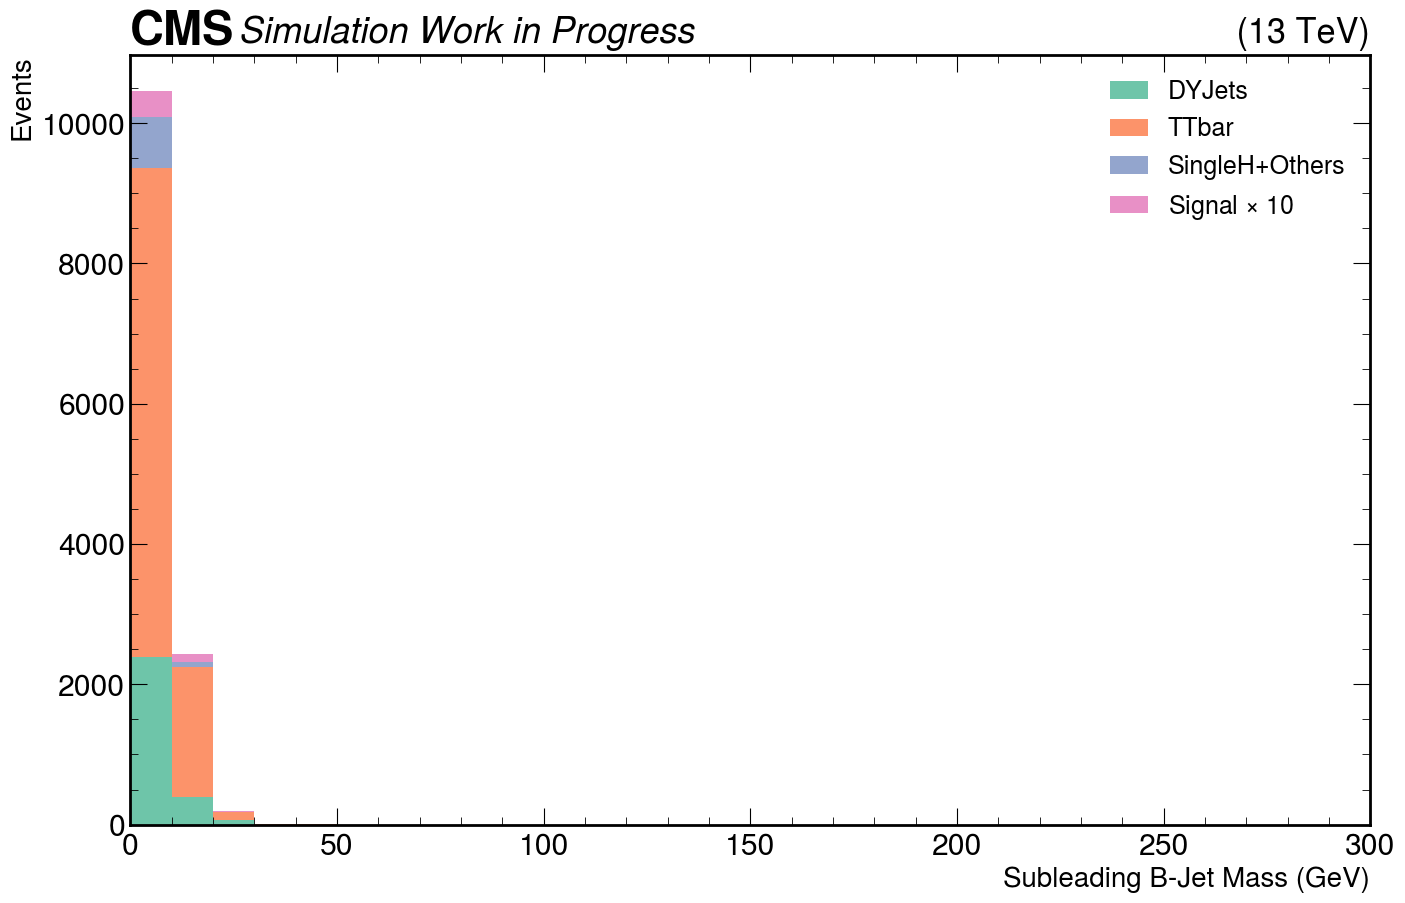

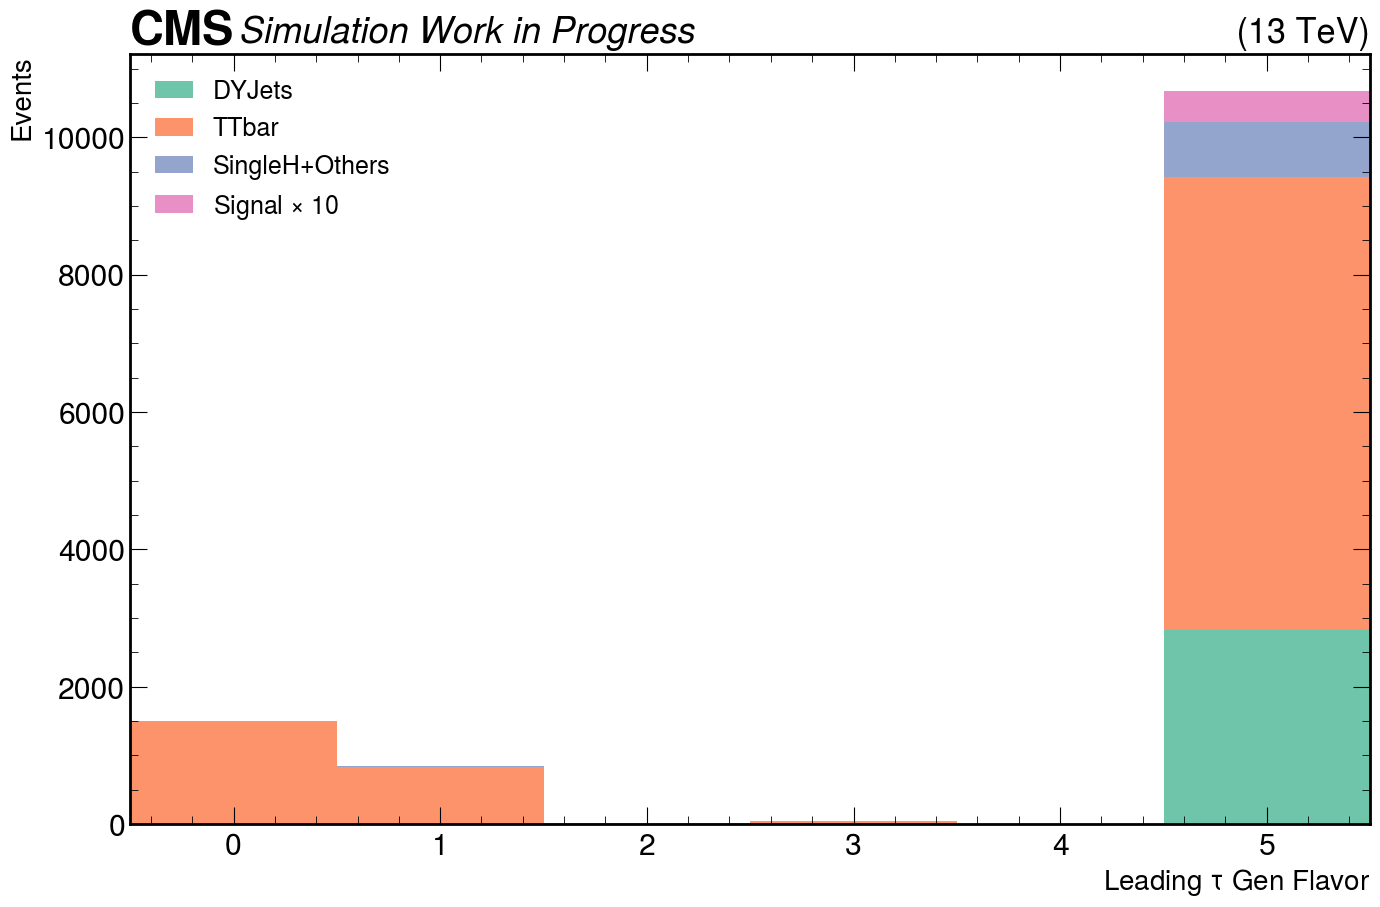

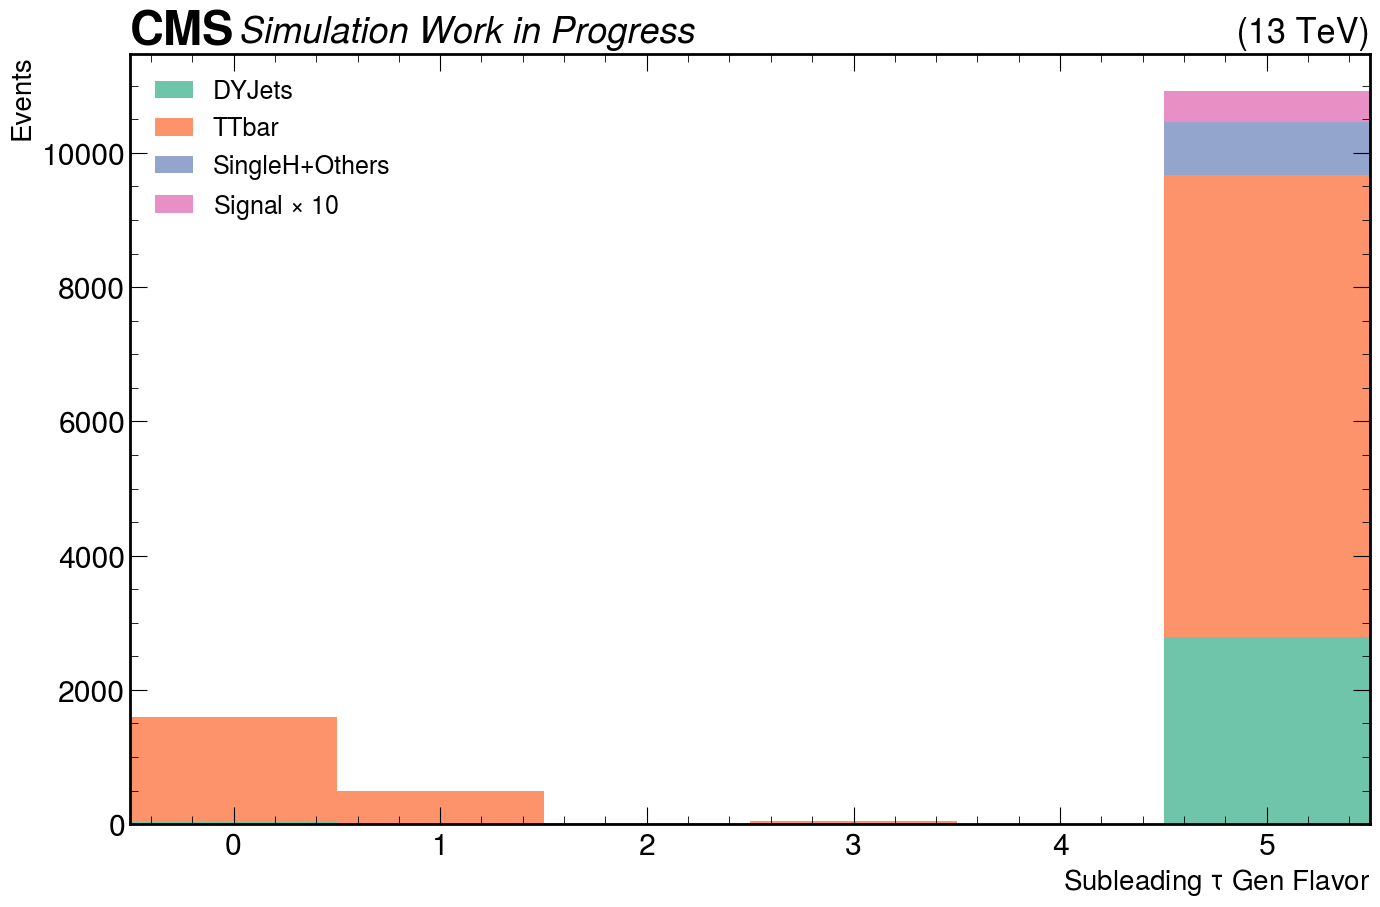

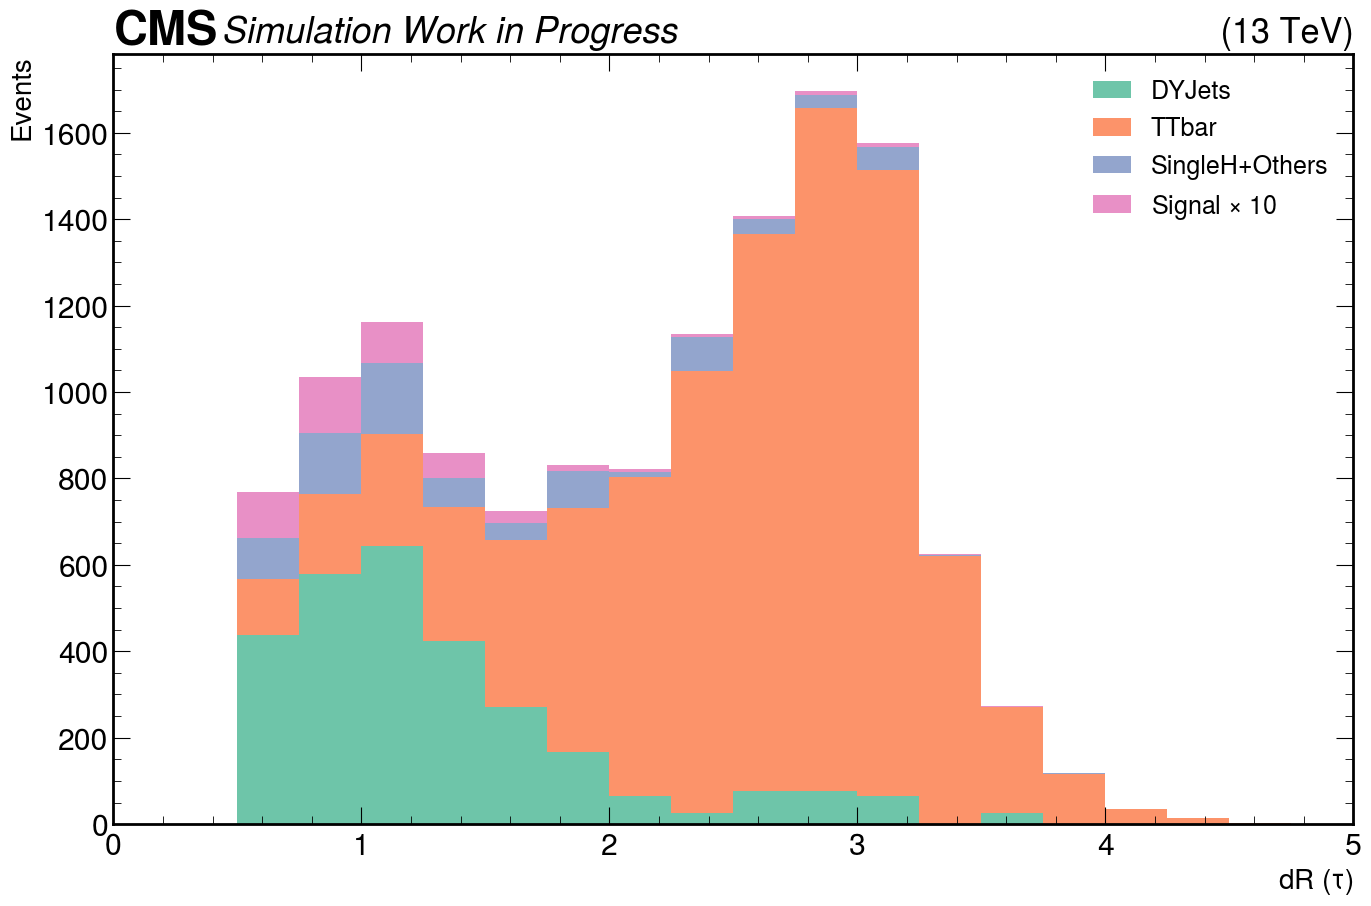

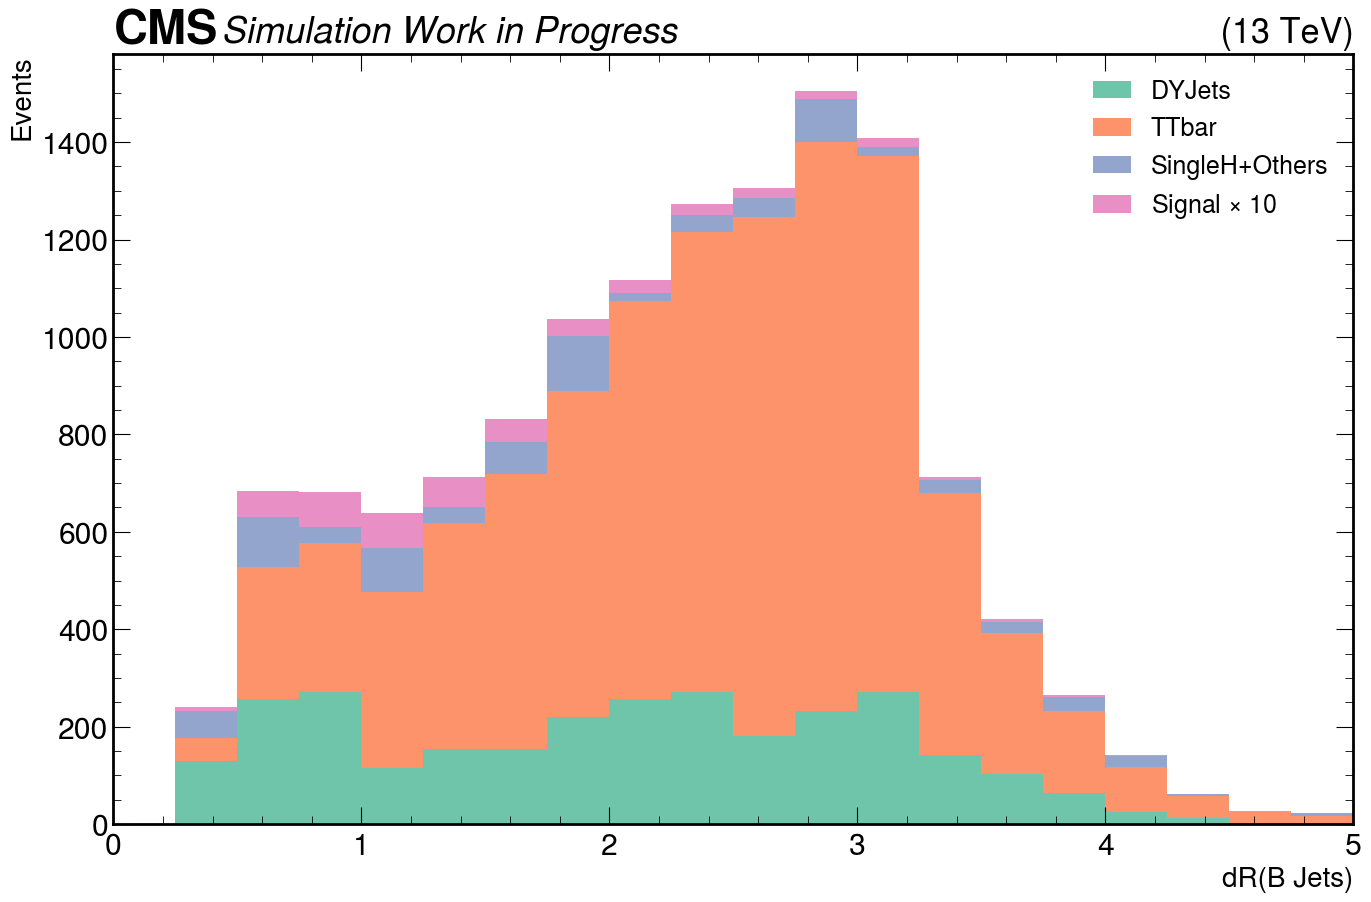

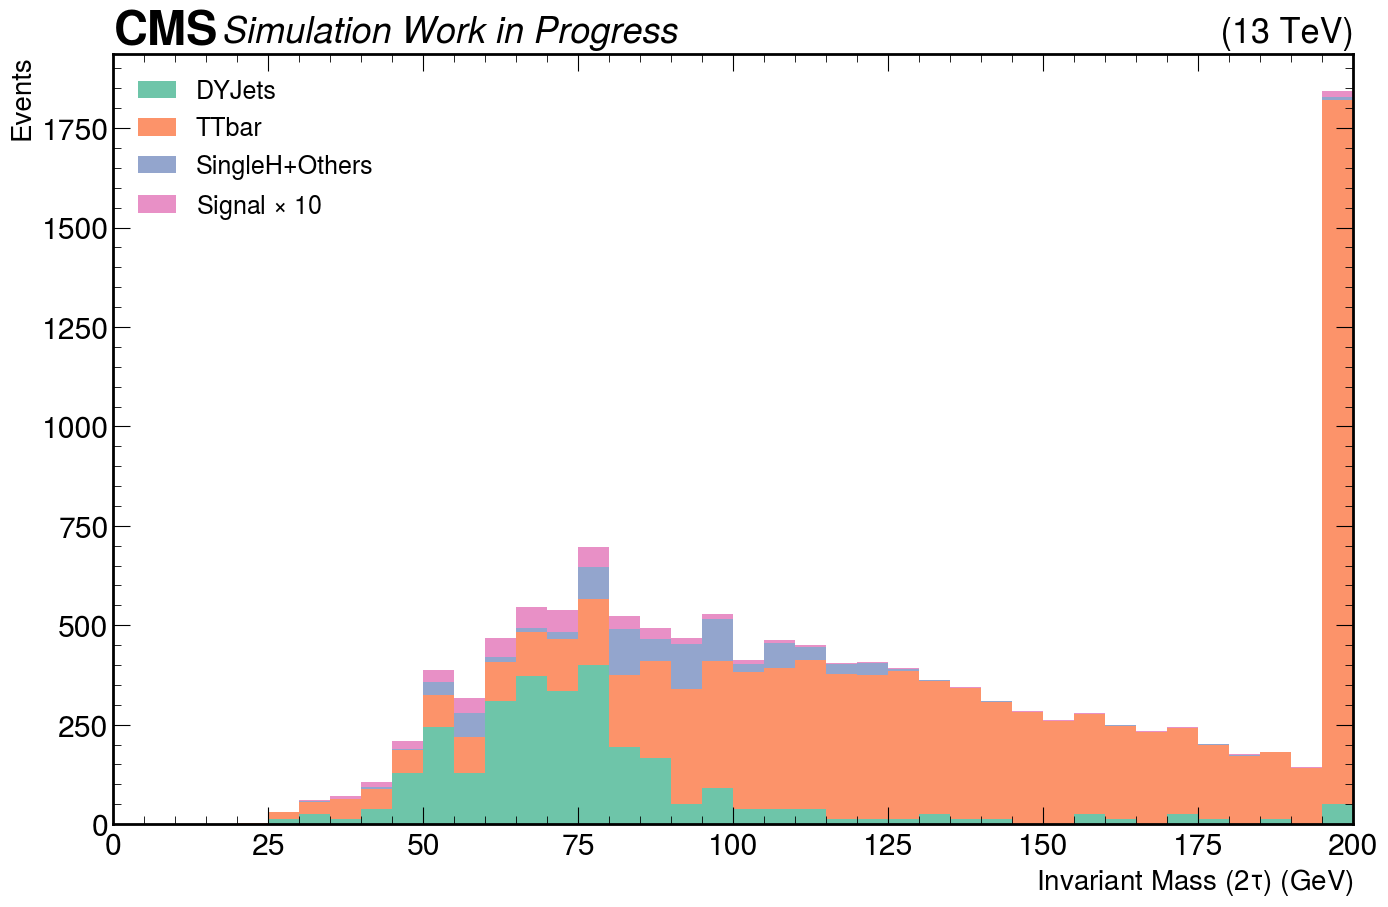

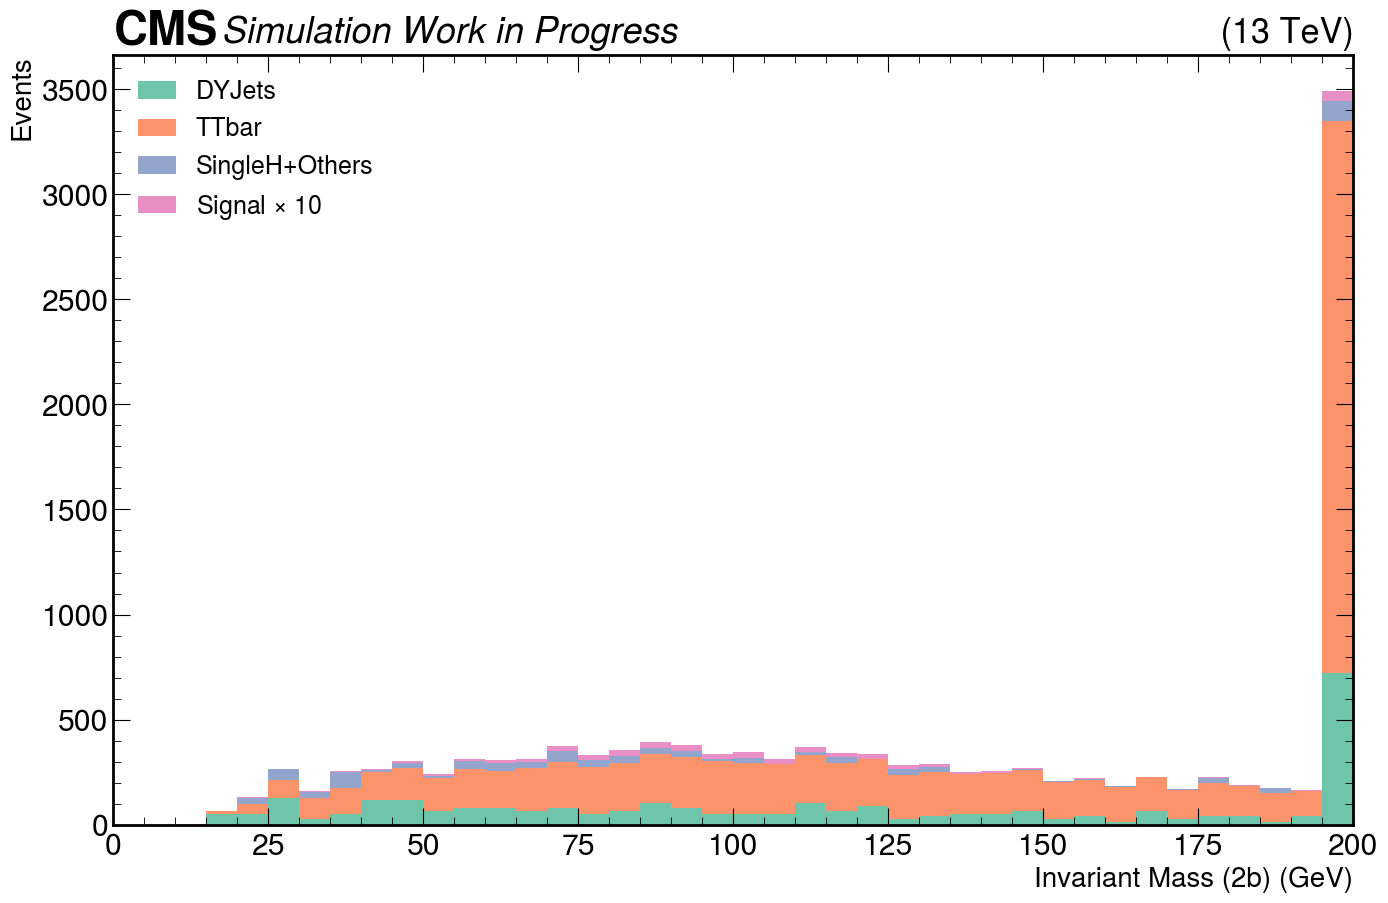

In [51]:
cp = CSVPlotter()
